<a href="https://colab.research.google.com/github/JD-man/DeepLearning_Study/blob/main/Chapter5/Chapter_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 오토인코더

# 오토인코더는 지금까지 사용한 전방향 신경망과 다르다.
# 원본 입력을 압축(compressed)한 잠재 표현(latent representation)을 학습한다.
# CNN과는 달리 비지도 학습 기법이다.

# 인코더와 디코더로 구성된다.
# 인코더는 입력을 압축 표현으로 인코딩하는 학습
# 디코더는 압축표현에서 원래 입력을 복원하는 역할

In [ ]:
# 잠재표현

# 입력과 비슷한 출력을 생성하는 신경망을 만드는 이유는 입력을 더 작은 차원으로 압축하면 입력의 두드러진 특성(잠재표현)을 학습하기 때문
# 이렇게 학습한 잠재표현은 입력 중 가장 중요한 특징만 반영한다.

# 오토인코더가 학습한 잠재 표현의 활용

# 1. 입력 데이터의 차원을 줄일 수 있다.
# 2. 입력 데이터으 노이즈를 줄일 수 있다.

In [ ]:
# 오토인코더는 JPEG와 같은 이미지 압축이나 MP3와 같은 오디오 압축보다 성능이 떨어진다.
# 오토인코더로 학습한 잠재 표현은 훈련에 사용한 데이터만 표현할 수 있기 때문이다.
# 오토인코더는 훈련에 사용한 것과 유사한 이미지에서만 잘 동작한다.
# 오토인코더는 손실 압축 알고리즘에 가깝다.
# 따라서 일반 압축 기술로 오토인코더를 사용하기에 부족하다.

In [2]:
# MNIST 데이터셋을 이용한 실습

# 케라스에 내장된 MNIST 데이터셋을 임포트
from keras.datasets import mnist

training_set, testing_set = mnist.load_data()
X_train, y_train = training_set
X_test, y_test = testing_set

11493376/11490434 [==============================] - 0s 0us/step


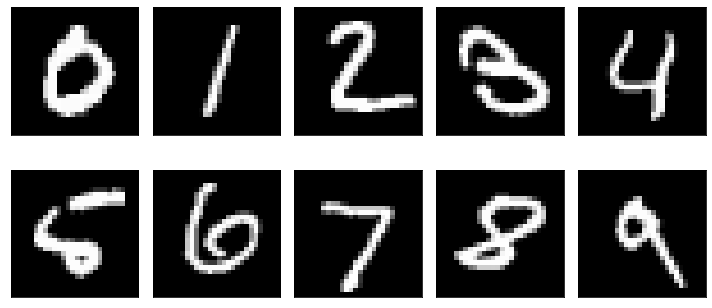

In [3]:
import matplotlib.pyplot as plt
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(10,5))

# ax는 ax1부터 0~9의 자리이다. 그냥 test_set에서 각자리에 맞는 숫자 찾아서 출력하는 코드임
for idx, ax in enumerate([ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10]):
  for i in range(1000):
    if y_test[i] == idx:
      ax.imshow(X_test[i], cmap='gray')
      ax.grid(False)
      ax.set_xticks([])
      ax.set_yticks([])
      break

plt.tight_layout()
plt.show()


In [ ]:
# 위와 같은 숫자들이 인코더에 들어가 잠재표현을 학습하고 디코더를 통해 원래 이미지를 재생성한다.

# 7 -> 인코더 -> 잠재표현 -> 디코더 -> 7

# 은닉 레이어 (잠재표현 레이어)는 입력 데이터보다 더 적은 차원으로 구성해야 한다.
# 얼마나 적은 차원으로 구성할지 결정해야한다.

# 입력의 특징을 압축해 표현할 수 있을 정도로 충분히 작아야한다.
# 디코더가 큰 손실없이 입력을 복원할 수 있을 정도로는 커야한다.

In [7]:
# 기본 오토인코더 만들기

from keras.models import Sequential

model = Sequential()

# 은닉레이어는 Dense 레이어다. 이미지 크기가 (28,28)이므로 input_shape = (784,)이다.
# 지금은 유닛(노드)수를 1개로 만들며, 활성화 함수는 ReLU를 사용한다.

from keras.layers import Dense

hidden_layer_size = 1
model.add(Dense(units=hidden_layer_size, input_shape=(784,), activation='relu'))

# 출력레이어도 Dense 레이어다. 출력이미지 크기는 입력이미지의 크기와 같아야 하므로 노드 수는 784개여야한다.
# 출력값이 (픽셀당) 0과 1사이로 제한되므로 시그모이드 활성화 함수를 사용한다.

model.add(Dense(units=784, activation='sigmoid'))

# 모델확인
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 785       
_________________________________________________________________
dense_1 (Dense)              (None, 784)               1568      
Total params: 2,353
Trainable params: 2,353
Non-trainable params: 0
_________________________________________________________________


In [8]:
# 기본 오토인코더 모델 생성 함수를 만들어놓는다. 나중에 은닉레이어 수를 조절하는데 쓰임.

def create_basic_autoencoder(hidden_layer_size):
  model = Sequential()
  model.add(Dense(units=hidden_layer_size, input_shape=(784,), activation='relu'))
  model.add(Dense(units=784, activation='sigmoid'))
  model.summary()
  return model

# 함수로 모델 생성
model = create_basic_autoencoder(hidden_layer_size=1)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 785       
_________________________________________________________________
dense_3 (Dense)              (None, 784)               1568      
Total params: 2,353
Trainable params: 2,353
Non-trainable params: 0
_________________________________________________________________


In [9]:
# 데이터 전처리

# X는 (데이터개수, 가로크기, 세로크기)로 되어있다. 가로 세로는 반대일 수 있음.
# 이미지값은 0~255로 되어있어 0~1로 정규화를 시켜준다.

X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1]*X_test.shape[2]))

X_train_reshaped = X_train_reshaped / 255.
X_test_reshaped = X_test_reshaped / 255.

In [10]:
# 모델 컴파일

# 옵티마이저는 adam, 손실함수는 mse
# 손실함수가 mse인 이유는 입력값과 출력값 사이의 오차를 정량화해야하기 때문이다.

model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# 모델 훈련

# 에폭은 10으로 지정. 입력과 출력이 X_train_reshaped이다. 오토인코더의 출력은 입력을 복원하는것이므로 똑같이 맞춰야한다.

model.fit(X_train_reshaped, X_train_reshaped, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0604
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0604
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0604
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0604
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0604
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0604
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0604
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0604
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0604
Epoch 10/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0604


In [ ]:
# 훈련된 모델을 테스트 데이터에 적용
output = model.predict(X_test_reshaped)

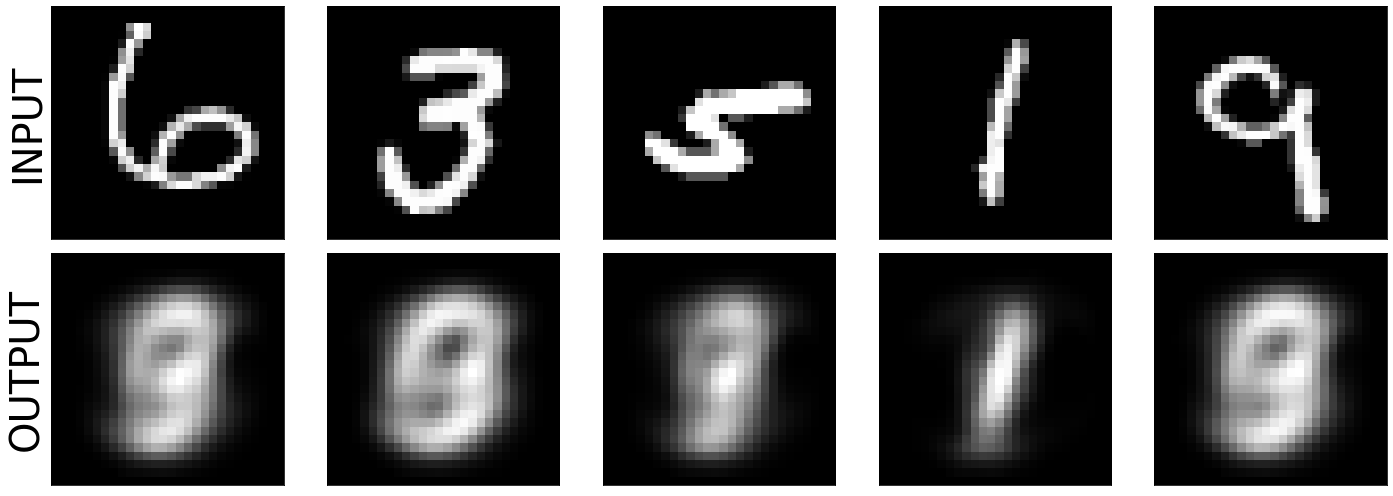

In [ ]:
# 출력을 원본과 비교하기

import random
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, figsize=(20,7))

# 이미지 다섯개의 인덱스를 고른다
randomly_selected = random.sample(range(output.shape[0]), 5)

# 원본 이미지를 그린다
for i, ax in enumerate ([ax1, ax2, ax3, ax4, ax5]):
  ax.imshow(X_test[randomly_selected[i]], cmap='gray')
  if i == 0:
    ax.set_ylabel("INPUT", size=40)
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])

# 오토인코더가 출력한 이미지를 그린다
for i, ax in enumerate ([ax6, ax7, ax8, ax9, ax10]):
  ax.imshow(output[randomly_selected[i]].reshape(28,28), cmap='gray')
  if i == 0:
    ax.set_ylabel("OUTPUT", size=40)
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()
plt.show()

In [11]:
# 결과가 좋지 않다. 은닉레이어의 크기를 늘려 노드를 증가시켜 성능을 올려야한다.

hiddenLayerSize_2_model = create_basic_autoencoder(hidden_layer_size=2)
hiddenLayerSize_4_model = create_basic_autoencoder(hidden_layer_size=4)
hiddenLayerSize_8_model = create_basic_autoencoder(hidden_layer_size=8)
hiddenLayerSize_16_model = create_basic_autoencoder(hidden_layer_size=16)
hiddenLayerSize_32_model = create_basic_autoencoder(hidden_layer_size=32)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2)                 1570      
_________________________________________________________________
dense_5 (Dense)              (None, 784)               2352      
Total params: 3,922
Trainable params: 3,922
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 4)                 3140      
_________________________________________________________________
dense_7 (Dense)              (None, 784)               3920      
Total params: 7,060
Trainable params: 7,060
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
______

In [ ]:
hiddenLayerSize_2_model.compile(optimizer='adam', loss='mean_squared_error')
hiddenLayerSize_2_model.fit(X_train_reshaped, X_train_reshaped, epochs=10)

hiddenLayerSize_4_model.compile(optimizer='adam', loss='mean_squared_error')
hiddenLayerSize_4_model.fit(X_train_reshaped, X_train_reshaped, epochs=10)

hiddenLayerSize_8_model.compile(optimizer='adam', loss='mean_squared_error')
hiddenLayerSize_8_model.fit(X_train_reshaped, X_train_reshaped, epochs=10)

hiddenLayerSize_16_model.compile(optimizer='adam', loss='mean_squared_error')
hiddenLayerSize_16_model.fit(X_train_reshaped, X_train_reshaped, epochs=10)

hiddenLayerSize_32_model.compile(optimizer='adam', loss='mean_squared_error')
hiddenLayerSize_32_model.fit(X_train_reshaped, X_train_reshaped, epochs=10)


Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0896
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0598
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0580
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0573
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0568
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0567
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0564
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0561
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0560
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0560
Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0820
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0498
Epo

In [ ]:
output_2_model = hiddenLayerSize_2_model.predict(X_test_reshaped)
output_4_model = hiddenLayerSize_4_model.predict(X_test_reshaped)
output_8_model = hiddenLayerSize_8_model.predict(X_test_reshaped)
output_16_model = hiddenLayerSize_16_model.predict(X_test_reshaped)
output_32_model = hiddenLayerSize_32_model.predict(X_test_reshaped)

In [1]:
fig, axes = plt.subplots(7, 5, figsize=(15,15))

randomly_selected = random.sample(range(output.shape[0]), 5) # 위에서 썼던 레이어 1개짜리 그대로 사용
outputs = [X_test, output, output_2_model, output_4_model, output_8_model, output_16_model, output_32_model]

print(axes.shape)
print(axes[0].shape)

for row_num, row in enumerate(axes):
  for col_num, ax in enumerate(row):
    ax.imshow(outputs[row_num][randomly_selected[col_num]].reshape(28,28), cmap='gray')
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

NameError: ignored

In [ ]:
test_mat = [[1,2],
            [3,4],
            [5,6]]

print(test_mat)
print("#############################################################")
for idx, mat in enumerate(test_mat):
  print(mat)

print("#############################################################")

for idx, mat in enumerate(test_mat):
  for idx2, mat2 in enumerate(mat):
    print(mat2)

# 행렬을 enumerate하면 row를 먼저 나눈다. 나누어진 row를 다시 enumerate하면 해당 row column으로 나누어진다. 혼자해봣음

[[1, 2], [3, 4], [5, 6]]
#############################################################
[1, 2]
[3, 4]
[5, 6]
#############################################################
1
2
3
4
5
6


In [ ]:
# 오토인코더를 사용한 노이즈 제거

# 오토인코더는 노이즈 제거(디노이징)에도 사용할 수 있다.
# 노이즈는 이미지 화소의 밝기가 임의로 바뀌는 현상이다. 보통 카메라의 센서 때문에 발생한다.

# 초기에는 이미지에 필터를 적용하는 방식으로 접근했다.
# 하지만 이 기법은 완벽하게 노이즈를 제거하지 못했다.

# 오토인코더를 이용해 노이즈가 많은 이미지를 입력하고 디코더로 깨끗한 이미지를 출력해볼 수 있다.

In [12]:
# MNIST 데이터셋에 인위적인 노이즈 넣기.
# 원본 이미지의 각 화소에 -0.5와 0.5 사이의 무작위수를 더한다.
# 넘파이를 이용해 실행한다.

# 노이즈 더하기
import numpy as np

X_train_noisy = X_train_reshaped + np.random.normal(0, 0.5, size=X_train_reshaped.shape)
X_test_noisy = X_test_reshaped + np.random.normal(0, 0.5, size=X_test_reshaped.shape)

# 노이즈를 더한 결과를 정규화

X_train_noisy = np.clip(X_train_noisy, a_min=0, a_max=1)
X_test_noisy = np.clip(X_test_noisy, a_min=0, a_max=1)


In [13]:
# 기본 오토인코더 생성

basic_denoise_autoencoder = create_basic_autoencoder(hidden_layer_size=16)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 16)                12560     
_________________________________________________________________
dense_15 (Dense)             (None, 784)               13328     
Total params: 25,888
Trainable params: 25,888
Non-trainable params: 0
_________________________________________________________________


In [15]:
# 컴파일 후 학습
basic_denoise_autoencoder.compile(optimizer='adam', loss='mean_squared_error')
basic_denoise_autoencoder.fit(X_train_noisy, X_train_reshaped, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0667
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0324
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0310
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0309
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0307
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0305
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0305
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0304
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0302
Epoch 10/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0301


In [16]:
# 모델을 테스트 데이터셋에 적용
output = basic_denoise_autoencoder.predict(X_test_noisy)

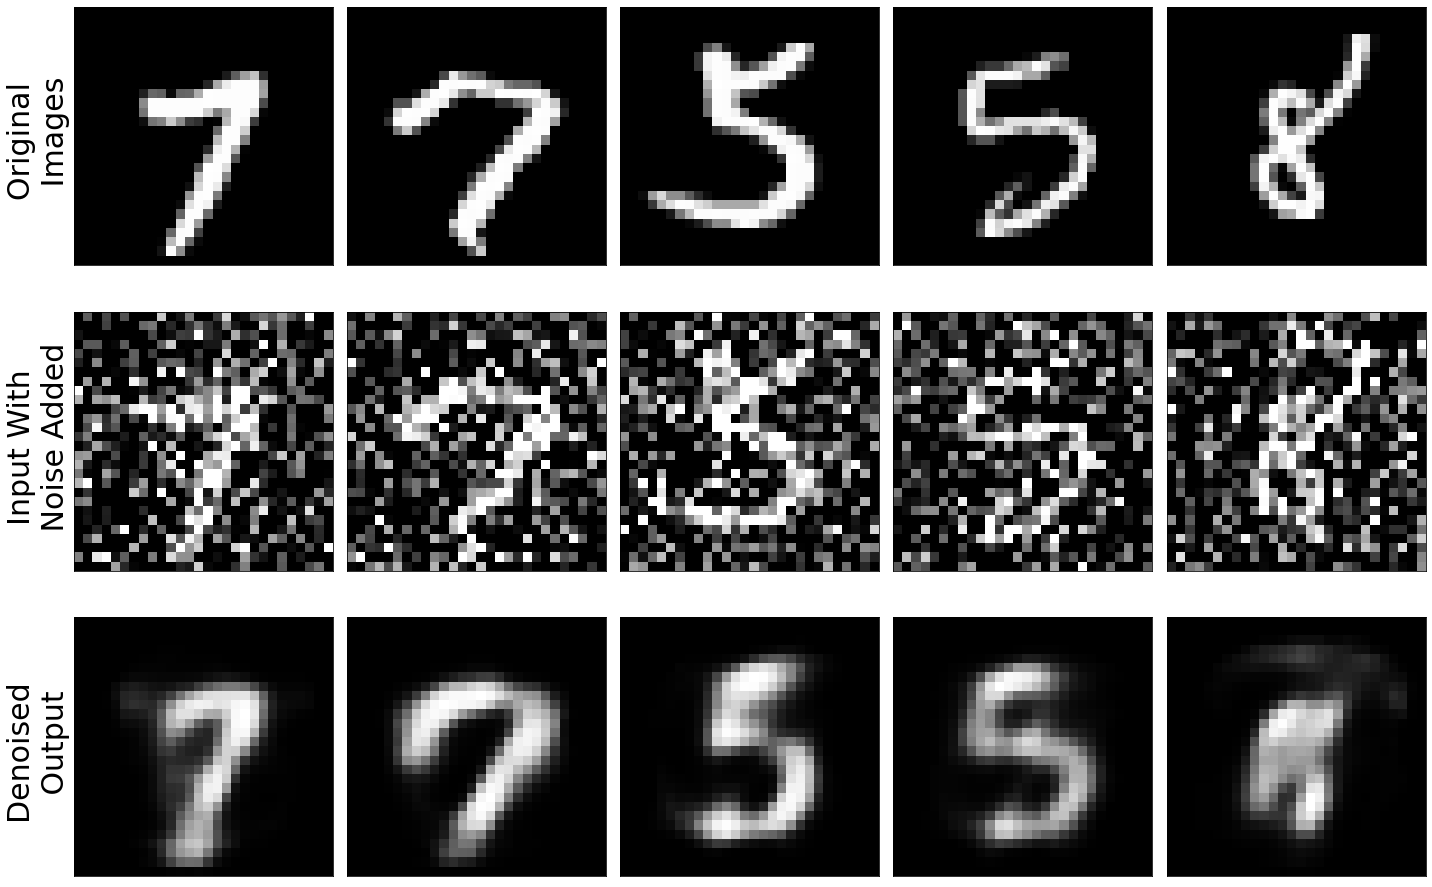

In [18]:
import random
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10), (ax11, ax12, ax13, ax14, ax15)) = plt.subplots(3, 5, figsize=(20,13))

# 이미지 다섯개의 인덱스를 고른다
randomly_selected = random.sample(range(output.shape[0]), 5)

# 원본 이미지를 그린다
for i, ax in enumerate ([ax1, ax2, ax3, ax4, ax5]):
  ax.imshow(X_test_reshaped[randomly_selected[i]].reshape(28,28), cmap='gray')
  if i == 0:
    ax.set_ylabel("Original \n Images", size=30)
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])

# 노이즈 이미지를 그린다
for i, ax in enumerate ([ax6, ax7, ax8, ax9, ax10]):
  ax.imshow(X_test_noisy[randomly_selected[i]].reshape(28,28), cmap='gray')
  if i == 0:
    ax.set_ylabel("Input With \n Noise Added", size=30)
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])  

# 결과를 그린다
for i, ax in enumerate ([ax11, ax12, ax13, ax14, ax15]):
  ax.imshow(output[randomly_selected[i]].reshape(28,28), cmap='gray')
  if i == 0:
    ax.set_ylabel("Denoised \n Output", size=30)
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
# 결과는 크게 만족스럽지 않다. 노이즈를 잘 제거했지만 원본 이미지를 제대로 복원하지 못했다.

In [ ]:
# 심층 컨볼루션 오토인코더를 사용한 노이즈 제거

# 심층 CNN으로 은닉 레이어 한 개짜리 오토인코더를 개선할 수 있다.
# 은닉 레이어를 한개 대신 여러개 사용해 신경망의 깊이를 늘리고, Dense 대신 Convolution을 사용한다.

# 입력 -> 컨 -> 컨 -> 잠재표현 -> 컨 -> 컨 -> 출력
#         (인코더)                (디코더)

# 컨볼루션 레이어 설정

# 필터개수 : 인코더에는 레이어를 추가할수록 필터 수를 줄인다. 디코더는 늘린다. 인코더 16->8 / 디코더 8->16
# 필터크기 : 3X3
# 패딩 : 오토인코더에는 same을 입력해 다음 레이어로 출력할 이미지의 높이와 가로를 동일하게 유지한다. 결국 원본입력과 출력의 차원을 동일하게 만든다.

In [21]:
# 모델 생성
conv_autoencoder = Sequential()

from keras.layers import Conv2D

# 인코더 추가
conv_autoencoder.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same', input_shape=(28,28,1)))
conv_autoencoder.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same'))

# 디코더 추가
conv_autoencoder.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same'))
conv_autoencoder.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'))

# 출력레이어 추가. 이미지를 하나만 출력하므로 필터를 한개만 사용한다.
conv_autoencoder.add(Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same'))

# 모델 확인
conv_autoencoder.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 8)         1160      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 8)         584       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 16)        1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 1)         145       
Total params: 3,217
Trainable params: 3,217
Non-trainable params: 0
_________________________________________________________________


In [22]:
# 컴파일 후 훈련
conv_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
conv_autoencoder.fit(X_train_noisy.reshape(60000,28,28,1), X_train_reshaped.reshape(60000,28,28,1), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 10s 2ms/step - loss: 0.1795
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1016
Epoch 3/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1005
Epoch 4/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0997
Epoch 5/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0989
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0985
Epoch 7/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0980
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0978
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0976
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0973


In [24]:
# 테스트 데이터셋에 모델 적용
output = conv_autoencoder.predict(X_test_noisy.reshape(10000,28,28,1))

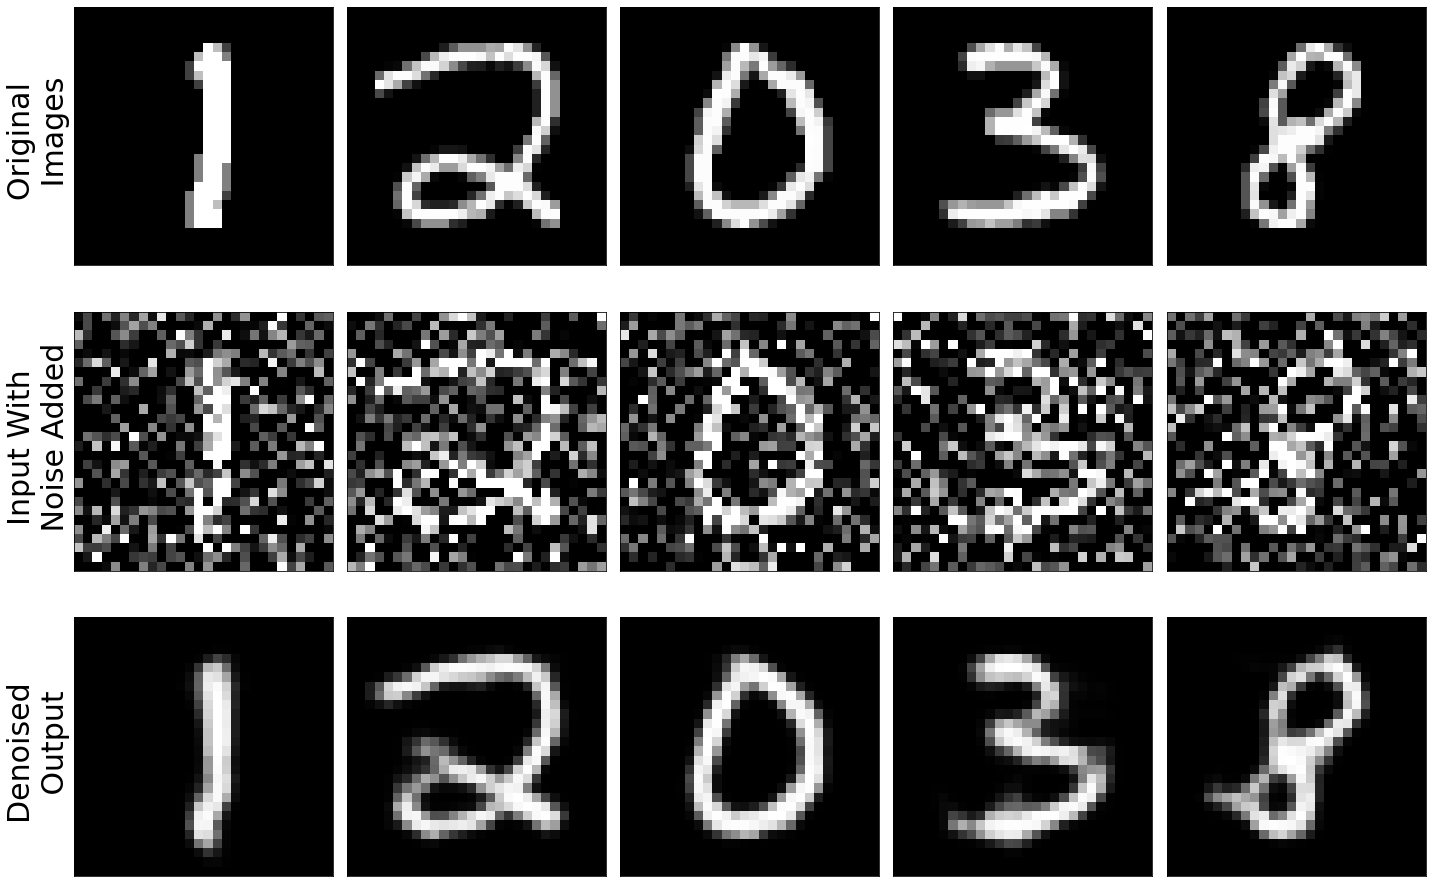

In [25]:
# 확인하기
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10), (ax11, ax12, ax13, ax14, ax15)) = plt.subplots(3, 5, figsize=(20,13))

# 이미지 다섯개의 인덱스를 고른다
randomly_selected = random.sample(range(output.shape[0]), 5)

# 원본 이미지를 그린다
for i, ax in enumerate ([ax1, ax2, ax3, ax4, ax5]):
  ax.imshow(X_test_reshaped[randomly_selected[i]].reshape(28,28), cmap='gray')
  if i == 0:
    ax.set_ylabel("Original \n Images", size=30)
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])

# 노이즈 이미지를 그린다
for i, ax in enumerate ([ax6, ax7, ax8, ax9, ax10]):
  ax.imshow(X_test_noisy[randomly_selected[i]].reshape(28,28), cmap='gray')
  if i == 0:
    ax.set_ylabel("Input With \n Noise Added", size=30)
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])  

# 결과를 그린다
for i, ax in enumerate ([ax11, ax12, ax13, ax14, ax15]):
  ax.imshow(output[randomly_selected[i]].reshape(28,28), cmap='gray')
  if i == 0:
    ax.set_ylabel("Denoised \n Output", size=30)
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()
plt.show()

In [ ]:
# 결과가 좋다. 이 프로젝트에서 만든 컨볼루션 모델은 비교적 단순하다.
# 딥러닝의 장점은 모델 복잡도를 얼마든지 늘려서 더 복잡한 데이터를 처리할 수 있는 확장성에 있다.

In [ ]:
# 오토인코더를 사용한 문서 노이즈 제거

# 이 프로젝트에 사용할 데이터셋은 노이즈가 섞인 이미지 216장이 있다.
# 스캔, 구겨짐, 커피얼룩 등 다양한 원인으로 노이즈가있다.
# Noisy_Documents 폴더 아래에 noisy, clean 폴더가 있다.

In [27]:
# Noisy_Documents에 접근

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [30]:
cd /content/gdrive/MyDrive/Dataset/

/content/gdrive/MyDrive/Dataset


In [31]:
!ls

Noisy_Documents  PetImages


In [32]:
noisy_imgs_path = "Noisy_Documents/noisy/"
clean_imgs_path = "Noisy_Documents/clean/"

In [33]:
# 폴더 아래의 PNG 파일들은 케라스의 load_img, img_to_array 함수를 사용해 넘파이 배열로 변환할 수 있다.

import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array

X_train_noisy = []

for file in sorted(os.listdir(noisy_imgs_path)):
  img = load_img(noisy_imgs_path+file, color_mode='grayscale', target_size=(420,540))
  img = img_to_array(img).astype('float32')/255
  X_train_noisy.append(img)

X_train_noisy = np.array(X_train_noisy)

# 변환확인 (216, 420, 540, 1)

print(X_train_noisy.shape)

(216, 420, 540, 1)


In [34]:
X_train_clean = []

for file in sorted(os.listdir(clean_imgs_path)):
  img = load_img(clean_imgs_path+file, color_mode='grayscale', target_size=(420,540))
  img = img_to_array(img).astype('float32')/255
  X_train_clean.append(img)

X_train_clean = np.array(X_train_clean)

# 변환확인 (216, 420, 540, 1)

print(X_train_clean.shape)

(216, 420, 540, 1)


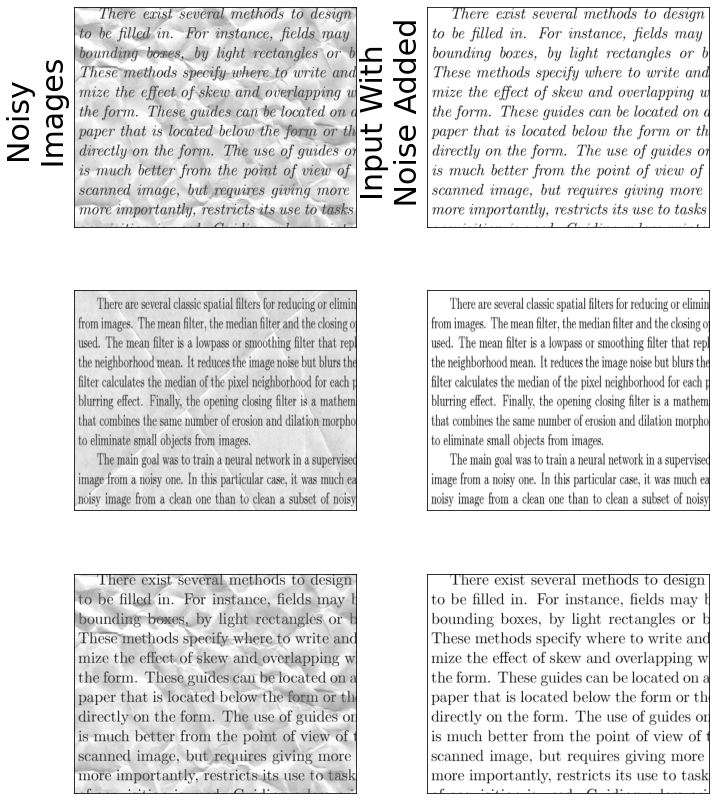

In [38]:
# 이미지 세개를 무작위로 골라 로드한 이미지 확인

import random

fig, ((ax1, ax2), (ax3, ax4), (ax5,ax6)) = plt.subplots(3,2,figsize=(10,12))

randomly_selected = random.sample(range(X_train_noisy.shape[0]), 3)

# 노이즈 이미지를 그린다
for i, ax in enumerate ([ax1, ax3, ax5]):
  ax.imshow(X_train_noisy[randomly_selected[i]].reshape(420,540), cmap='gray')
  if i == 0:
    ax.set_ylabel("Noisy \n Images", size=30)
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])

# 클린 이미지를 그린다
for i, ax in enumerate ([ax2, ax4, ax6]):
  ax.imshow(X_train_clean[randomly_selected[i]].reshape(420,540), cmap='gray')
  if i == 0:
    ax.set_ylabel("Clean \n Images", size=30)
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()
plt.show()

# Input with noise added는 오타. clean images 이다.

In [53]:
# 훈련데이터셋, 테스트데이터셋 나누기
# 랜덤으로 안나누고 그냥 순서대로 나눔

X_test_noisy = X_train_noisy[0:20,]
X_train_noisy = X_train_noisy[21:,]

X_test_clean = X_train_clean[0:20,]
X_train_clean = X_train_clean[21:,]

In [54]:
# 기본 컨볼루션 오토인코더
# 인코더, 디코더 각각 컨볼루션 레이어 1개 + 출력레이어

# 모델생성
basic_conv_autoencoder = Sequential()

# 인코더
basic_conv_autoencoder.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same', input_shape=(420, 540, 1)))

# 디코더
basic_conv_autoencoder.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same'))

# 출력레이어
basic_conv_autoencoder.add(Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same'))

# 모델확인
basic_conv_autoencoder.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 420, 540, 8)       80        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 420, 540, 8)       584       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 420, 540, 1)       73        
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


In [55]:
# 컴파일 후 훈련

basic_conv_autoencoder.compile(optimizer='adam', loss='binary_crossentropy') # 노이즈는 0, 글씨는 1이되어야하니 binary_crossentropy 하는듯
basic_conv_autoencoder.fit(X_train_noisy, X_train_clean, epochs=10)

Epoch 1/10
6/6 [==============================] - 1s 175ms/step - loss: 0.7104
Epoch 2/10
6/6 [==============================] - 1s 105ms/step - loss: 0.6102
Epoch 3/10
6/6 [==============================] - 1s 111ms/step - loss: 0.5075
Epoch 4/10
6/6 [==============================] - 1s 105ms/step - loss: 0.4150
Epoch 5/10
6/6 [==============================] - 1s 108ms/step - loss: 0.3439
Epoch 6/10
6/6 [==============================] - 1s 106ms/step - loss: 0.3016
Epoch 7/10
6/6 [==============================] - 1s 108ms/step - loss: 0.2826
Epoch 8/10
6/6 [==============================] - 1s 107ms/step - loss: 0.2811
Epoch 9/10
6/6 [==============================] - 1s 108ms/step - loss: 0.2782
Epoch 10/10
6/6 [==============================] - 1s 105ms/step - loss: 0.2736


In [56]:
# 모델적용

output = basic_conv_autoencoder.predict(X_test_noisy)

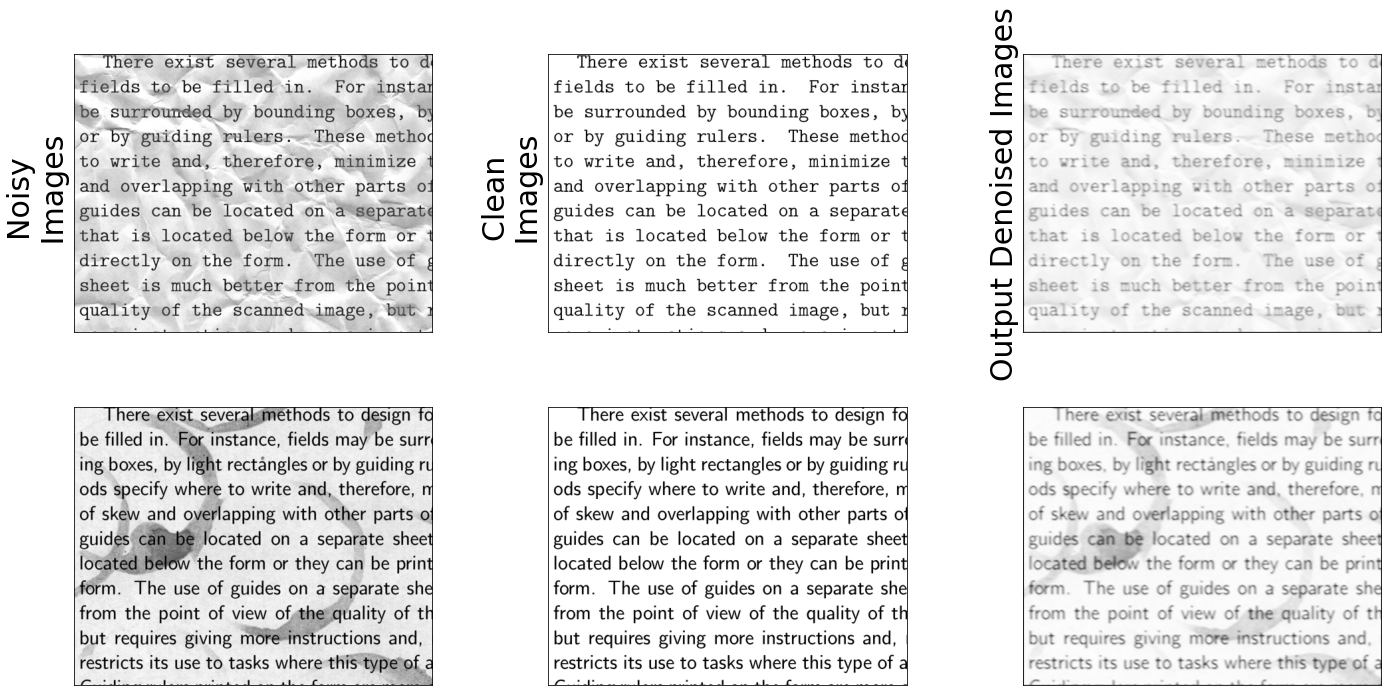

In [63]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20,10))

randomly_selected = random.sample(range(X_test_noisy.shape[0]), 2)

# 노이즈 이미지를 그린다
for i, ax in enumerate ([ax1, ax4]):
  idx = randomly_selected[i]
  ax.imshow(X_test_noisy[idx].reshape(420,540), cmap='gray')
  if i == 0:
    ax.set_ylabel("Noisy \n Images", size=30)
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])

# 클린 이미지를 그린다
for i, ax in enumerate ([ax2, ax5]):
  ax.imshow(X_test_clean[randomly_selected[i]].reshape(420,540), cmap='gray')
  if i == 0:
    ax.set_ylabel("Clean \n Images", size=30)
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])

# 결과 이미지를 그린다
for i, ax in enumerate ([ax3, ax6]):
  ax.imshow(output[randomly_selected[i]].reshape(420,540), cmap='gray')
  if i == 0:
    ax.set_ylabel("Output Denoised Images", size=30)
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()
plt.show()

In [74]:
# 결과가 아주 완벽하지는 않아 모델 깊이를 늘리고 필터수를 늘려서 다시 만든다.

# 심층 컨볼루션 오토인코더

conv_autoencoder2 = Sequential()

# 인코더
conv_autoencoder2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(420, 540, 1)))
conv_autoencoder2.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'))
conv_autoencoder2.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same'))

# 디코더
conv_autoencoder2.add(Conv2D(filters=8, kernel_size=(3,3), activation='relu', padding='same'))
conv_autoencoder2.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'))
conv_autoencoder2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))

# 출력레이어
conv_autoencoder2.add(Conv2D(filters=1, kernel_size=(3,3), activation='sigmoid', padding='same'))

# 모델 확인
conv_autoencoder2.summary()



Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 420, 540, 32)      320       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 420, 540, 16)      4624      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 420, 540, 8)       1160      
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 420, 540, 8)       584       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 420, 540, 16)      1168      
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 420, 540, 32)      4640      
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 420, 540, 1)     

In [75]:
# 컴파일 후 훈련

conv_autoencoder2.compile(optimizer='adam', loss='binary_crossentropy')
conv_autoencoder2.fit(X_train_noisy, X_train_clean, epochs=10)

Epoch 1/10
6/6 [==============================] - 4s 509ms/step - loss: 0.6750
Epoch 2/10
6/6 [==============================] - 3s 494ms/step - loss: 0.4813
Epoch 3/10
6/6 [==============================] - 3s 496ms/step - loss: 0.3299
Epoch 4/10
6/6 [==============================] - 3s 495ms/step - loss: 0.2918
Epoch 5/10
6/6 [==============================] - 3s 496ms/step - loss: 0.2884
Epoch 6/10
6/6 [==============================] - 3s 499ms/step - loss: 0.2564
Epoch 7/10
6/6 [==============================] - 3s 503ms/step - loss: 0.2304
Epoch 8/10
6/6 [==============================] - 3s 502ms/step - loss: 0.2033
Epoch 9/10
6/6 [==============================] - 3s 506ms/step - loss: 0.1780
Epoch 10/10
6/6 [==============================] - 3s 505ms/step - loss: 0.1594


In [77]:
output3 = conv_autoencoder2.predict(X_test_noisy)

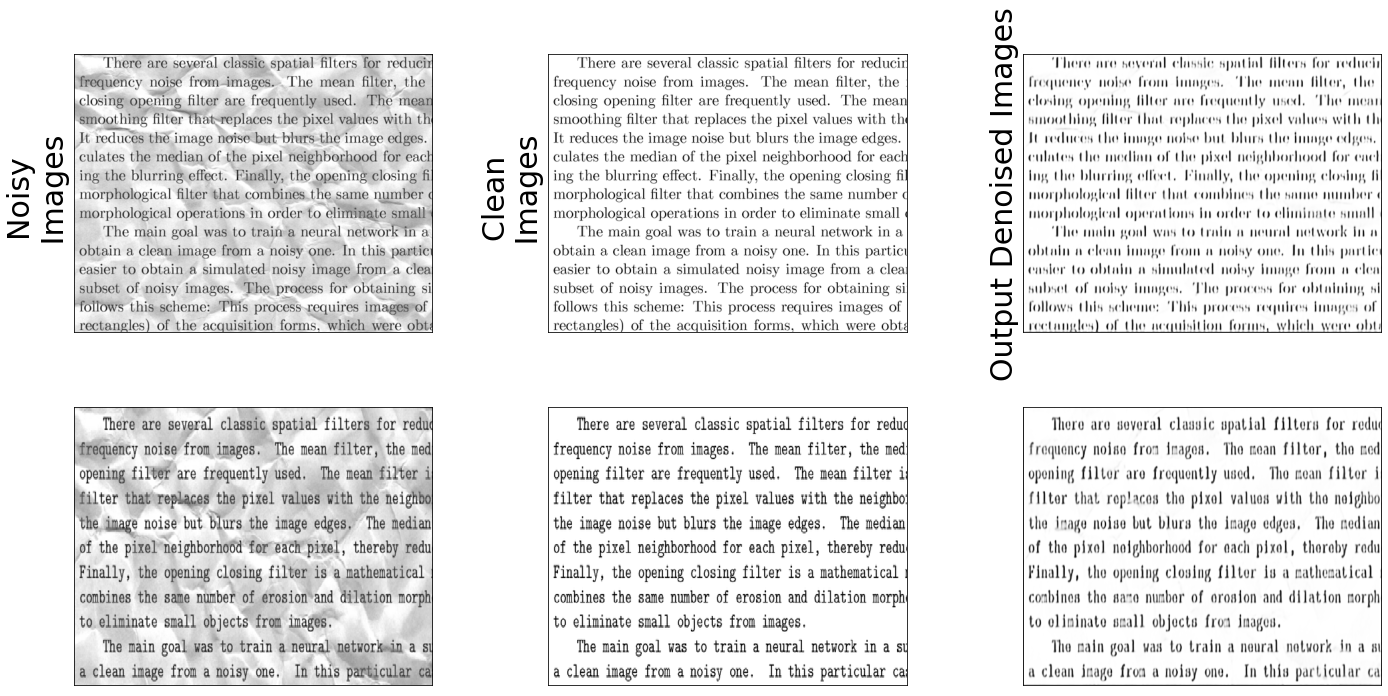

In [81]:
# 결과확인

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(20,10))

randomly_selected = random.sample(range(X_test_noisy.shape[0]), 2)

# 노이즈 이미지를 그린다
for i, ax in enumerate ([ax1, ax4]):
  idx = randomly_selected[i]
  ax.imshow(X_test_noisy[idx].reshape(420,540), cmap='gray')
  if i == 0:
    ax.set_ylabel("Noisy \n Images", size=30)
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])

# 클린 이미지를 그린다
for i, ax in enumerate ([ax2, ax5]):
  ax.imshow(X_test_clean[randomly_selected[i]].reshape(420,540), cmap='gray')
  if i == 0:
    ax.set_ylabel("Clean \n Images", size=30)
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])

# 결과 이미지를 그린다
for i, ax in enumerate ([ax3, ax6]):
  ax.imshow(output3[randomly_selected[i]].reshape(420,540), cmap='gray')
  if i == 0:
    ax.set_ylabel("Output Denoised Images", size=30)
  ax.grid(False)
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout()
plt.show()